# Linear regression tutorial
**Author:** Scott Campit

## Summary
This notebook is a tutorial to write up a linear regressor written from scratch. We will use the carbig dataset built into MATLAB to predict MPG based on all other numerical datasets that are not categoricals. First, we will build a linear regressor using gradient descent. Then we will use the normal equation to compute the regression coefficient. Finally, we'll use sklearn functions to train a model.

## Construct the regression dataset
Let X be attributes that are useful to predict MPG, which includes:


1.   Acceleration
2.   Displacement
3.   Horsepower
4.   Weight

Y is the MPG associated with the given attributes.

In [27]:
import numpy as np

# Load files into Google Colab using GUI
#from google.colab import files
#files.upload()

# This code loads the .mat files into a dict, then extracting the values into a numpy array.
import scipy.io
X = scipy.io.loadmat('X.mat')
Y = scipy.io.loadmat('Y.mat')
X = X['X']
Y = Y['Y']

# Normalize the data
mu = np.nanmean(X)
sigma = np.nanstd(X)
X = np.divide((X - mu), sigma)

# Detect and remove NaNs
Y = Y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(Y).any(axis=1)]
Y = Y[~np.isnan(Y).any(axis=1)]
print(X.shape)
print(Y.shape)

[[-0.61743969 -0.39377463 -0.52797367  2.03014805]
 [-0.61781878 -0.36117261 -0.50143714  2.17344532]
 [-0.61819788 -0.38543458 -0.51280994  1.97859136]
 ...
 [-0.61774297 -0.52418273 -0.56285025  1.1135004 ]
 [-0.61243566 -0.53555553 -0.56664119  1.36370199]
 [-0.61182911 -0.53631372 -0.56436663  1.43572972]]
6
(392, 4)
(392, 1)
[[-0.61743969 -0.39377463 -0.52797367  2.03014805]
 [-0.61781878 -0.36117261 -0.50143714  2.17344532]
 [-0.61819788 -0.38543458 -0.51280994  1.97859136]
 ...
 [-0.61774297 -0.52418273 -0.56285025  1.1135004 ]
 [-0.61243566 -0.53555553 -0.56664119  1.36370199]
 [-0.61182911 -0.53631372 -0.56436663  1.43572972]]


## Split into training and test sets
Next, we have to split the data into a training and test set. We'll write our own implementation of the `trainTestSplit` function.

In [2]:
def trainTestSplit(X, Y, trainingSize=0.8, randomState=0):
  idx = np.arange(1, np.shape(X)[0])
  trainIdx = np.random.choice(idx, 
                              size=round(trainingSize*np.shape(X)[0]), 
                              replace=False)
  return X[trainIdx, :], Y[trainIdx, :], np.delete(X, trainIdx, axis=0), np.delete(Y, trainIdx, axis=0)

In [43]:
Xtrain, Ytrain, Xtest, Ytest = trainTestSplit(X, Y)
print(Xtrain)
print(Ytrain)

[[-0.61402785 -0.45594594 -0.54692833  2.11279039]
 [-0.6170606  -0.57346487 -0.55071927  1.20827373]
 [-0.61364876 -0.53555553 -0.55981751  1.61541996]
 ...
 [-0.61326966 -0.5431374  -0.56057569  1.39933677]
 [-0.61425531 -0.55223564 -0.5772558   0.92395374]
 [-0.61478604 -0.47641698 -0.5545102   1.52140481]]
[[18. ]
 [23.7]
 [23. ]
 [14. ]
 [28. ]
 [26. ]
 [32.1]
 [12. ]
 [13. ]
 [13. ]
 [18.5]
 [37. ]
 [20.5]
 [15. ]
 [36.1]
 [13. ]
 [22. ]
 [36.4]
 [20. ]
 [46.6]
 [21. ]
 [19. ]
 [25. ]
 [19.1]
 [23.9]
 [23. ]
 [13. ]
 [32. ]
 [29.5]
 [36. ]
 [39.1]
 [31. ]
 [29. ]
 [20.8]
 [22.5]
 [36. ]
 [18. ]
 [21.5]
 [27.2]
 [23. ]
 [34.2]
 [18. ]
 [35.1]
 [30.5]
 [28. ]
 [13. ]
 [41.5]
 [16. ]
 [15.5]
 [27. ]
 [19.8]
 [17.6]
 [13. ]
 [21. ]
 [25.4]
 [36. ]
 [21.1]
 [25. ]
 [19. ]
 [16. ]
 [44.3]
 [44.6]
 [32.2]
 [18. ]
 [38. ]
 [16. ]
 [38. ]
 [26. ]
 [30. ]
 [15. ]
 [15. ]
 [26. ]
 [16. ]
 [15. ]
 [18. ]
 [16. ]
 [20.2]
 [34. ]
 [22. ]
 [33. ]
 [29. ]
 [13. ]
 [25. ]
 [18. ]
 [29. ]
 [32. ]


## Initialize the regression coefficients and intercept to be small and random numbers
First, we need to initialize the regression coefficients to be some small, arbitrary value with the size of the number of predictors. The intercept needs to be the number of samples in the dataset by one column.

In [46]:
beta = np.multiply(np.random.normal(size=Xtrain.shape[1]), 0.01)
intercept = np.multiply(np.random.normal(size=Xtrain.shape[0]), 0.01)

## Define necessary training functions
Included in this repository are some additional functions we need to run the linear regressor. Here are the necessary components: training phase (forward propagation), cost evaluation, and learning phase (backward propagation + gradient descent). 

In [47]:
def forwardProp(Xtrain, beta, intercept):
  yhat = np.zeros((Xtrain.shape[0], 1))
  yhat = np.dot(Xtrain, beta.T) + intercept
  return yhat

def costEvaluation(Ytrain, Yhat):
  J = np.multiply(1 / Ytrain.shape[0], np.sum(np.square(Yhat - Ytrain)))
  return J

def backProp(Xtrain, Ytrain, Yhat, alpha, beta, intercept):
  dB = np.dot(np.divide(2, Xtrain.shape[0]), -np.sum(np.dot(Xtrain.T, Ytrain-Yhat), axis=1))
  dInt = np.dot(np.divide(2, Xtrain.shape[0]), -np.sum(Ytrain - Yhat, axis=1))

  beta = beta - np.dot(alpha, dB.T)
  intercept = intercept - np.dot(alpha, dInt)
  return beta, intercept

# Train the linear regressor
The next bit of code utilized all of the functions above to train a linear regressor. This for loop can be packaged into another function, but it is explicitly written below.

In [50]:
epochs = 1000
alpha = 0.001

J = list()
for i in range(epochs):
  yhat = forwardProp(Xtrain, beta, intercept)
  J.append(costEvaluation(Ytrain, yhat))
  beta, intercept = backProp(Xtrain, Ytrain, yhat, alpha, beta, intercept)
print(J)

/home/scampit/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/scampit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys


[1.528483647744827e+194, 2.361844228042689e+194, 3.64957005969215e+194, 5.639390380812459e+194, 8.714101482376453e+194, 1.3465208030910524e+195, 2.080671514812921e+195, 3.2150962262267786e+195, 4.968032517534172e+195, 7.676705566054804e+195, 1.1862202620434343e+196, 1.832971836648852e+196, 2.832345611901917e+196, 4.376598431499456e+196, 6.762809506761146e+196, 1.0450031717684821e+197, 1.6147602973504205e+197, 2.495160673518886e+197, 3.855573360882646e+197, 5.957710899708671e+197, 9.20597686575516e+197, 1.4225263944405805e+198, 2.1981169107729718e+198, 3.396575256746798e+198, 5.248457631258415e+198, 8.110024193457219e+198, 1.2531775435651419e+199, 1.9364355989997294e+199, 2.9922199358965147e+199, 4.623639510346448e+199, 7.1445424399365084e+199, 1.103989326197041e+200, 1.705906910908947e+200, 2.6360022870071748e+200, 4.073204705762475e+200, 6.29399930979666e+200, 9.725616602494146e+200, 1.5028221905185692e+201, 2.3221916189209446e+201, 3.5882980361940895e+201, 5.544711595564797e+201, 8.5

## Plot the MSE curve
Let's now see how the error or cost reduces with each iteration.

Text(0, 0.5, 'Cost (J)')

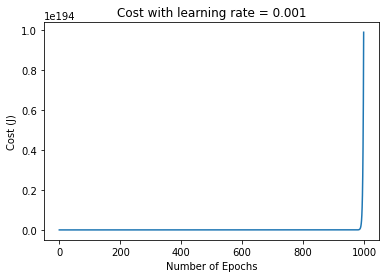

In [49]:
import matplotlib.pyplot as plt
plt.plot(J)
plt.title("Cost with learning rate = 0.001")
plt.xlabel("Number of Epochs")
plt.ylabel("Cost (J)")